In [183]:
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lem

In [184]:
tf.test.is_gpu_available()
tf.test.is_built_with_cuda()

True

# Setting Required Variables

In [185]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>" #out of vocab
training_size = 20000

# Reading json File

In [186]:
df = pd.read_json("sarcasm.json")

In [187]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [188]:
df.drop_duplicates(inplace = True)

# Visualizing Sarcastic Data

Text(0.5, 1.0, 'Sarcasm')

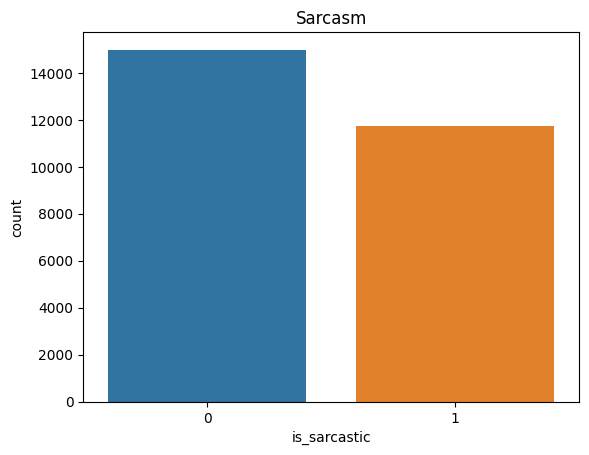

In [189]:
sns.countplot(x=df["is_sarcastic"])
plt.title('Sarcasm')

# Showing words that are related to sarcastic and  which are not

In [190]:
sarcastic = df[df['is_sarcastic']==1]['headline'].tolist()
genuine = df[df['is_sarcastic']==0]['headline'].tolist()

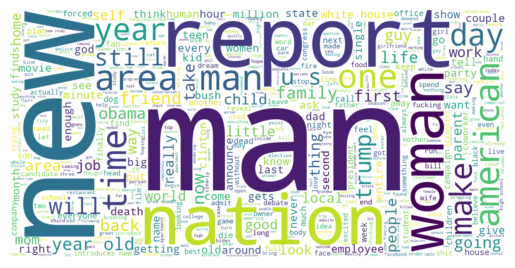

In [191]:
wordcloud = WordCloud(max_words=500, width=1200, height = 600, background_color='white').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

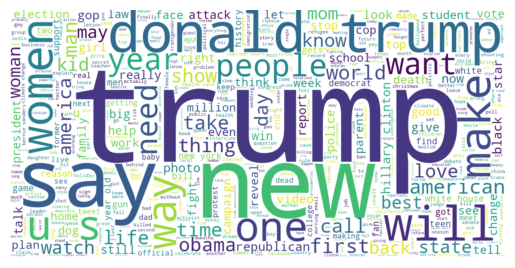

In [12]:
wordcloud = WordCloud(max_words=500, width=1200, height = 600, background_color='white').generate(" ".join(genuine))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Converting DataFrame Columns to array

In [192]:
sentences = np.array(df['headline'])
labels = np.array(df['is_sarcastic'])

# Splitting Dataset 80/20

In [193]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.2)
print('Train and Test set distribution: ', len(x_train), len(x_test), len(y_train), len(y_test))

Train and Test set distribution:  21366 5342 21366 5342


In [194]:
# Tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)


train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(x_test)
val_padded = pad_sequences(val_sequences, padding=padding_type, maxlen = max_length)

In [18]:
word_index = tokenizer.word_index

In [19]:
word_index 

{'<OOV>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'this': 19,
 'by': 20,
 'out': 21,
 'after': 22,
 'up': 23,
 'be': 24,
 'how': 25,
 'that': 26,
 'as': 27,
 'it': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'his': 32,
 'what': 33,
 'all': 34,
 'who': 35,
 'he': 36,
 'just': 37,
 'has': 38,
 'more': 39,
 'will': 40,
 'why': 41,
 'into': 42,
 'have': 43,
 'one': 44,
 'year': 45,
 'report': 46,
 'area': 47,
 'donald': 48,
 'over': 49,
 'u': 50,
 'says': 51,
 's': 52,
 'can': 53,
 'day': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'her': 58,
 'like': 59,
 'old': 60,
 'no': 61,
 "trump's": 62,
 'off': 63,
 'obama': 64,
 'life': 65,
 'get': 66,
 'an': 67,
 'house': 68,
 'now': 69,
 'people': 70,
 "'": 71,
 'women': 72,
 'still': 73,
 'was': 74,
 'white': 75,
 'than': 76,
 'make': 77,
 'my': 78,
 'clinton': 79,
 'i': 80,
 'back': 81,
 '

# Building Model

In [20]:
training_label = np.array(y_train)
val_label = np.array(y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.5, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [21]:
val_label

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 16)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 120, 64)          12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                        

# Training Data

In [23]:
num_epochs= 100
history=model.fit(train_padded, training_label, epochs =num_epochs, validation_data=(val_padded, val_label))

Epoch 1/100
668/668 [==============================] - 34s 39ms/step - loss: 0.5649 - acc: 0.6932 - val_loss: 0.4184 - val_acc: 0.8053
Epoch 2/100
668/668 [==============================] - 24s 36ms/step - loss: 0.4612 - acc: 0.7870 - val_loss: 0.3969 - val_acc: 0.8074
Epoch 3/100
668/668 [==============================] - 24s 37ms/step - loss: 0.4429 - acc: 0.7938 - val_loss: 0.3883 - val_acc: 0.8122
Epoch 4/100
668/668 [==============================] - 24s 36ms/step - loss: 0.4328 - acc: 0.8010 - val_loss: 0.3849 - val_acc: 0.8188
Epoch 5/100
668/668 [==============================] - 24s 35ms/step - loss: 0.4270 - acc: 0.8058 - val_loss: 0.3866 - val_acc: 0.8158
Epoch 6/100
668/668 [==============================] - 24s 37ms/step - loss: 0.4257 - acc: 0.8031 - val_loss: 0.3935 - val_acc: 0.8182
Epoch 7/100
668/668 [==============================] - 24s 36ms/step - loss: 0.4190 - acc: 0.8049 - val_loss: 0.3882 - val_acc: 0.8197
Epoch 8/100
668/668 [==============================] - 

# Saving Model

In [24]:
model.save('model_C4.h5')

# Plotting Acc and val_acc

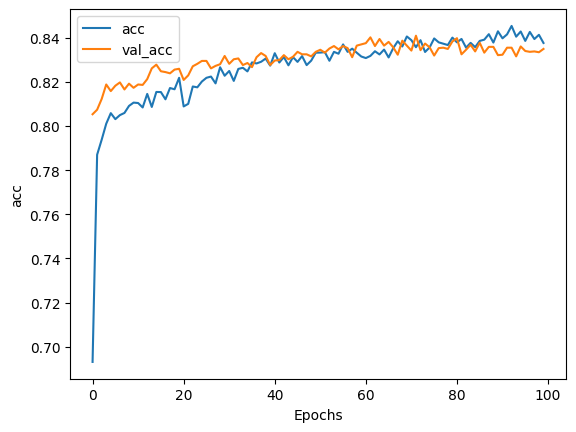

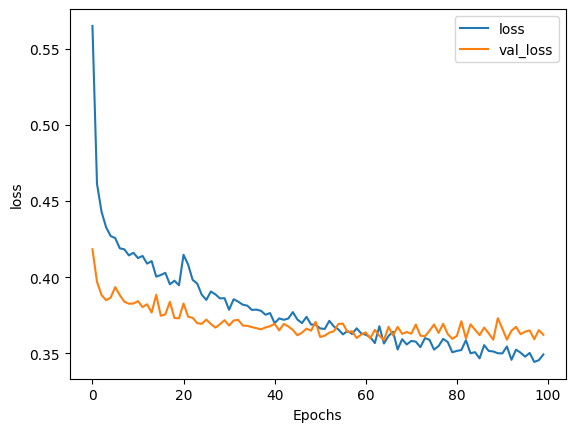

In [25]:
# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
# Plot the accuracy and loss
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [26]:
from keras.models import load_model
model = load_model('model_C4.h5')

In [27]:
val_padded.shape

(5342, 120)

In [28]:
val_label.shape

(5342,)

In [29]:
import pandas as pd
df = pd.DataFrame(val_padded,index = val_label)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
1,1,1,233,1,31,1,21,259,165,0,...,0,0,0,0,0,0,0,0,0,0
0,18,240,502,25,19,229,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,64,758,1,359,157,1,157,1,8,0,...,0,0,0,0,0,0,0,0,0,0
0,472,441,1,5,4,187,8,528,0,0,...,0,0,0,0,0,0,0,0,0,0
0,802,145,2,66,251,165,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Predicting Validation Data

In [30]:
preds = model.predict(val_padded)

167/167 [==============================] - 4s 17ms/step


In [32]:
predict = []
for i in preds:
    if i < 0.5:
        predict.append(0)
    else:
        predict.append(1)

# Classification report

In [34]:
print('Accuracy on test set: ', model.evaluate(val_padded,val_label)[1]*100)

167/167 [==============================] - 4s 17ms/step - loss: 0.3622 - acc: 0.8349
Accuracy on test set:  83.489328622818


In [38]:
from sklearn.metrics import classification_report
print(classification_report(val_label, predict, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.88      0.81      0.84      2970
    Sarcastic       0.78      0.87      0.82      2372

     accuracy                           0.83      5342
    macro avg       0.83      0.84      0.83      5342
 weighted avg       0.84      0.83      0.84      5342



# Confussion Matrix

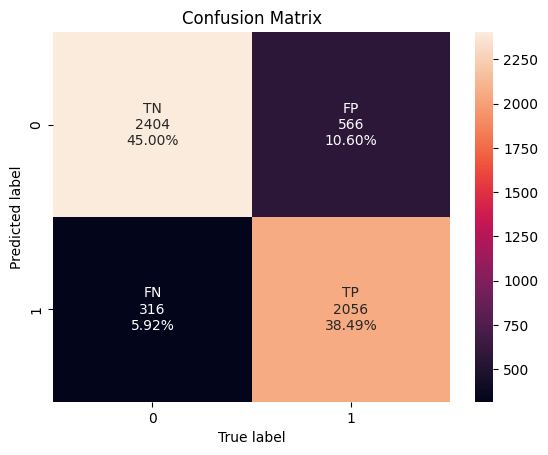

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=100)
cf = confusion_matrix(val_label, predict)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}"for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cf, annot=labels, fmt="")
plt.title('Confusion Matrix')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

# Predicting New Headline

In [246]:
new = np.array(['they re really on top of things',
                'That was my favorite show yet this tour',
                'Thank you for explaining that my eye cancer is nt going to make me deaf. I feel so fortunate that an intellectual giant like yourself would deign to operate on me',
               'I m glad we re having a rehearsal dinner. I rarely practice my meals before I eat',
               'savvy man registers sleepy romney twitter account just in case candidate looks tired',
               'third world disease eliminated with hot air hand dryers',
               'nasa now almost positive mars is rocky',
               'monster undeterred by night light',
               'longtime teacher retires without changing a single student s life']).astype(object)

In [247]:
new 

array(['they re really on top of things',
       'That was my favorite show yet this tour',
       'Thank you for explaining that my eye cancer is nt going to make me deaf. I feel so fortunate that an intellectual giant like yourself would deign to operate on me',
       'I m glad we re having a rehearsal dinner. I rarely practice my meals before I eat',
       'savvy man registers sleepy romney twitter account just in case candidate looks tired',
       'third world disease eliminated with hot air hand dryers',
       'nasa now almost positive mars is rocky',
       'monster undeterred by night light',
       'longtime teacher retires without changing a single student s life'],
      dtype=object)

In [248]:
coba = tokenizer.texts_to_sequences(new)
sentence_new = pad_sequences(coba, padding=padding_type, maxlen=max_length)

In [252]:
preds_new = model.predict(sentence_new)
new_predict = []
for i in preds_new:
    if i < 0.5:
        new_predict.append(0)
        print('not sarcastic')
    else:
        new_predict.append(1)
        print('sarcatic')


1/1 [==============================] - 0s 143ms/step
sarcatic
not sarcastic
sarcatic
not sarcastic
not sarcastic
not sarcastic
not sarcastic
sarcatic
not sarcastic
